<a href="https://colab.research.google.com/github/Abigail6on/Apple-Health-Sleep-Analysis/blob/main/sleep_hr_hrv_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep and Recovery Analysis

This notebook analyzes sleep patterns and recovery metrics using health tracking data from an XML export. The primary objective is to identify distinct sleep clusters based on physiological data (Heart Rate and Heart Rate Variability) and investigate their relationships with factors like the day of the week and screen time.

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install lxml

In [19]:
from lxml import etree

records = []
for event, element in etree.iterparse('/content/export.xml', events=("start",), recover=True):
    if element.tag == "Record":
        records.append(element.attrib)

df = pd.DataFrame(records)
# display(df.head())

# Data preprocessing


In [4]:
sleep_types = [
    'HKCategoryTypeIdentifierSleepAnalysis',
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
]

df_sleep = df[df['type'].isin(sleep_types)].copy()
df_sleep['value'] = pd.to_numeric(df_sleep['value'], errors='coerce')

df_sleep['startDate'] = pd.to_datetime(df_sleep['startDate'])
df_sleep['endDate'] = pd.to_datetime(df_sleep['endDate'])

df_sleep.dropna(subset=['value'], inplace=True)
# display(df_sleep.head())

In [5]:
df_heart_rate = df_sleep[df_sleep['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()
df_hrv = df_sleep[df_sleep['type'] == 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'].copy()

df_heart_rate['sleep_date'] = df_heart_rate['startDate'].dt.date
df_hrv['sleep_date'] = df_hrv['startDate'].dt.date

df_heart_rate['duration_minutes'] = (df_heart_rate['endDate'] - df_heart_rate['startDate']).dt.total_seconds() / 60
df_hrv['duration_minutes'] = (df_hrv['endDate'] - df_hrv['startDate']).dt.total_seconds() / 60

heart_rate_per_night = df_heart_rate.groupby('sleep_date')['value'].agg(['mean', 'std']).reset_index()
heart_rate_per_night.columns = ['sleep_date', 'mean_heart_rate', 'std_heart_rate']

hrv_per_night = df_hrv.groupby('sleep_date')['value'].agg(['mean', 'std']).reset_index()
hrv_per_night.columns = ['sleep_date', 'mean_hrv', 'std_hrv']

merged_features = pd.merge(heart_rate_per_night, hrv_per_night, on='sleep_date', how='outer')
merged_features.fillna(merged_features.select_dtypes(include=np.number).mean(), inplace=True)

# Drop the 'total_sleep_duration_minutes' column as it contains only NaNs
if 'total_sleep_duration_minutes' in merged_features.columns:
    merged_features = merged_features.drop(columns=['total_sleep_duration_minutes'])


display(merged_features.head())

,sleep_date,mean_heart_rate,std_heart_rate,mean_hrv,std_hrv
0,2024-02-14,64.810766,7.333132,61.068400,8.512642
1,2024-02-15,78.130345,18.832094,61.030883,31.777852
2,2024-02-16,77.491537,23.244466,78.866867,43.441845
3,2024-02-17,59.887125,9.985825,81.465183,23.853255
4,2024-02-18,73.351100,21.589782,71.243300,25.899718


# Clustering


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

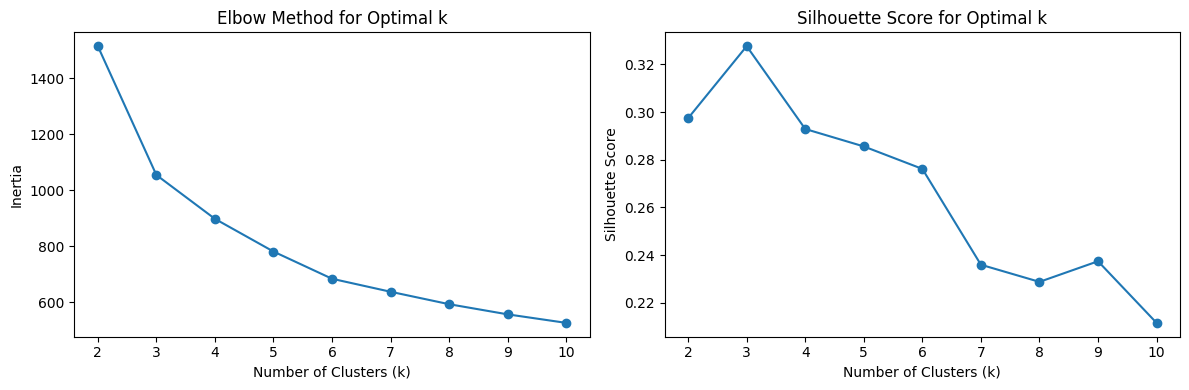

In [7]:
X = merged_features[['mean_heart_rate', 'std_heart_rate', 'mean_hrv', 'std_hrv']]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

In [8]:
# Based on the plots, let's choose k=3 as a reasonable number of clusters.
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
merged_features['cluster_label'] = kmeans.labels_

display(merged_features.head())

,sleep_date,mean_heart_rate,std_heart_rate,mean_hrv,std_hrv,cluster_label
0,2024-02-14,64.810766,7.333132,61.068400,8.512642,2
1,2024-02-15,78.130345,18.832094,61.030883,31.777852,1
2,2024-02-16,77.491537,23.244466,78.866867,43.441845,1
3,2024-02-17,59.887125,9.985825,81.465183,23.853255,1
4,2024-02-18,73.351100,21.589782,71.243300,25.899718,1


**Explanation of choosing k=3:**

The choice of k=3 as the optimal number of clusters was based on analyzing the two plots generated above: the Elbow Method and the Silhouette Score.

*   **Elbow Method:** This plot shows the inertia (a measure of how well the data is clustered) for different values of k. We look for an "elbow point" where the rate of decrease in inertia slows down. In the plot, there is a noticeable bend around k=3, suggesting that increasing the number of clusters beyond 3 provides diminishing returns in terms of reducing inertia.
*   **Silhouette Score:** This plot shows the silhouette score for different values of k. The silhouette score measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. The silhouette score for k=3 is relatively high compared to other values in the tested range, indicating that 3 clusters provide a reasonably good separation of the data points.

Considering both methods, k=3 was selected as a suitable number of clusters for this dataset.

# Analysis of clusters


In [9]:
cluster_characteristics = merged_features.groupby('cluster_label').mean(numeric_only=True)
display(cluster_characteristics)

,mean_heart_rate,std_heart_rate,mean_hrv,std_hrv
cluster_label,,,,
0,83.622109,20.687600,51.711228,15.790892
1,68.614343,14.979685,67.319851,29.301483
2,65.260945,10.792515,50.931770,15.370636


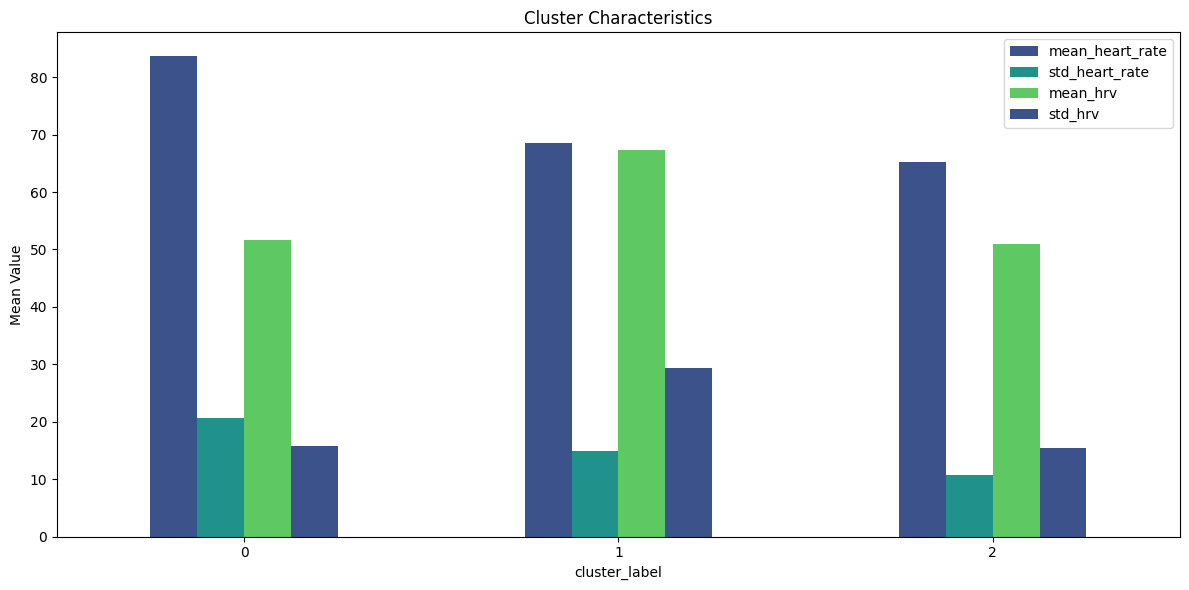

In [20]:
cluster_characteristics_for_plotting = cluster_characteristics[['mean_heart_rate', 'std_heart_rate', 'mean_hrv', 'std_hrv']]

cluster_characteristics_for_plotting.plot(kind='bar', figsize=(12, 6), color=sns.color_palette('viridis', len(cluster_characteristics_for_plotting)))
plt.title('Cluster Characteristics')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Summary


### Data Analysis Key Findings

*   Mean and standard deviation of Heart Rate and Heart Rate Variability, along with total sleep duration, were calculated per night and merged into a single DataFrame.
*   Missing values in the numerical columns of the merged DataFrame were imputed using the mean of their respective columns.
*   Based on the elbow method and silhouette score plots, the optimal number of clusters was determined to be 3.
*   KMeans clustering was applied with 3 clusters to group nights based on their heart rate and HRV characteristics.
*   The mean values of mean\_heart\_rate, std\_heart\_rate, mean\_hrv, and std\_hrv were calculated for each cluster to understand their distinct characteristics.

### Insights or Next Steps

*   Investigate the nights with missing `total_sleep_duration_minutes` to understand why this data is absent and determine if imputation or exclusion is the best approach for analyses involving sleep duration.
*   Characterize the three identified clusters in more detail by examining the average values of the features within each cluster and potentially visualizing the distribution of these features. This would help in labeling or describing the "types" of nights represented by each cluster.


# Characterize clusters

Analyze the mean values of Heart Rate and HRV for each cluster to describe their key differences.


In [11]:
cluster_descriptive_stats = merged_features.groupby('cluster_label')[['mean_heart_rate', 'std_heart_rate', 'mean_hrv', 'std_hrv']].agg(['mean', 'median', 'std', 'min', 'max'])
display(cluster_descriptive_stats)

mean_heart_rate                                              \
                         mean     median       std        min         max   
cluster_label                                                               
0                   83.622109  81.190891  9.472182  69.210320  118.836296   
1                   68.614343  67.614972  7.110284  55.419704   93.541188   
2                   65.260945  64.579549  4.709823  57.117805   81.317975   

              std_heart_rate                                             \
                        mean     median       std        min        max   
cluster_label                                                             
0                  20.687600  19.698571  5.408861  10.700747  43.926304   
1                  14.979685  15.144935  4.540153   7.037355  26.534183   
2                  10.792515  10.335309  2.815710   3.547785  18.680112   

                mean_hrv                                             \
                    mean     median       std        min        max   
cluster_label                                                         
0              51.711228  51.534592  7.720610  32.281960  70.907700   
1              67.319851  66.466827  7.214009  53.147467  91.054325   
2              50.931770  50.578139  6.610181  29.581550  69.578233   

                 std_hrv                                             
                    mean     median       std        min        max  
cluster_label                                                        
0              15.790892  16.072788  5.690719   3.129867  35.597727  
1              29.301483  28.017601  8.579790  13.829148  57.724469  
2              15.370636  14.545602  4.906337   2.043326  31.753336

Visualize the distribution of features within each cluster using box plots to further understand the differences between clusters.



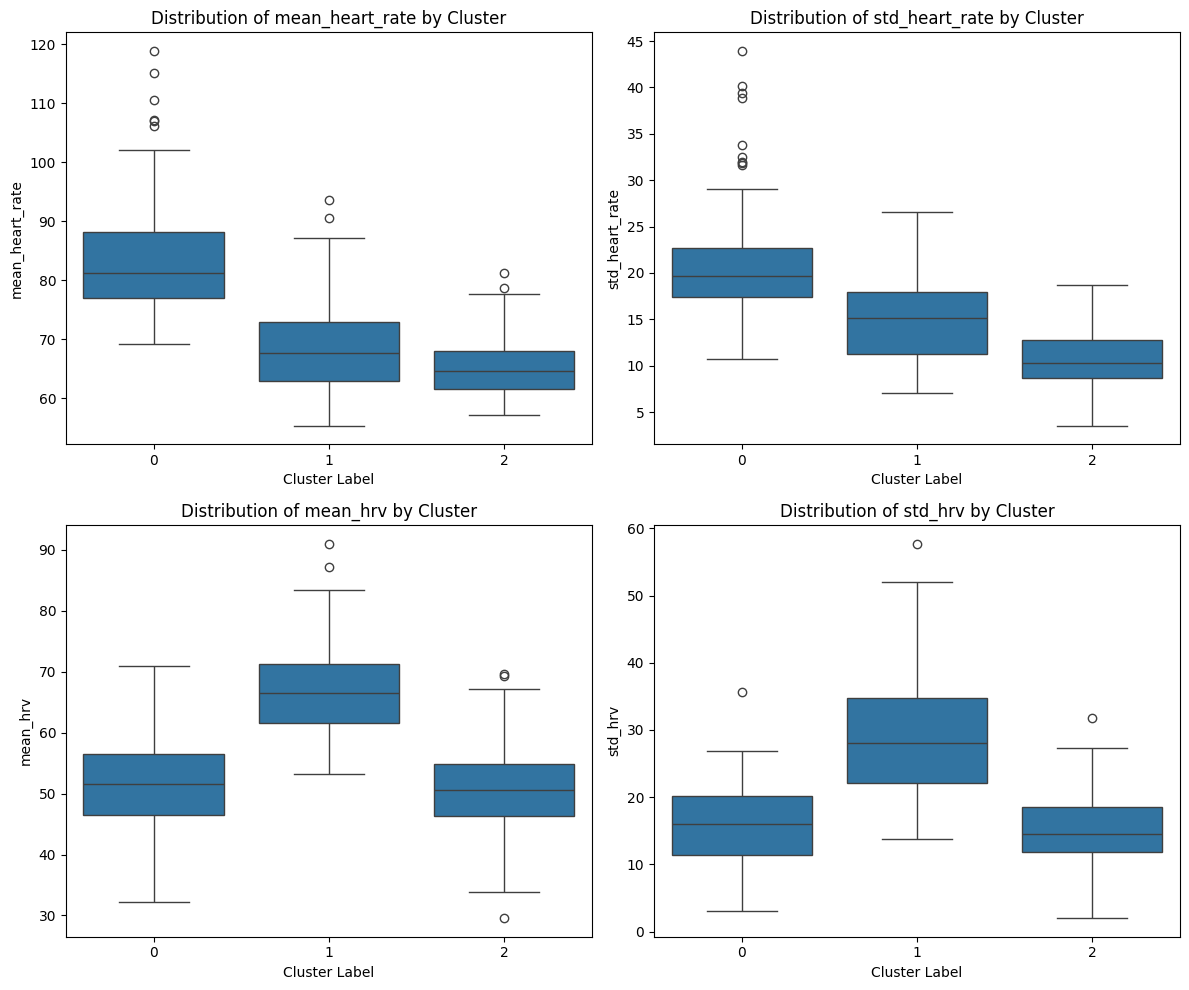

In [12]:
features_to_plot = ['mean_heart_rate', 'std_heart_rate', 'mean_hrv', 'std_hrv']
n_features = len(features_to_plot)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(12, n_rows * 5))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='cluster_label', y=feature, data=merged_features)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster Label')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Cross-reference with day of the week

Analyze the distribution of each cluster across different days of the week to see if certain sleep patterns are more common on specific days.


In [13]:
merged_features['sleep_date'] = pd.to_datetime(merged_features['sleep_date'])
merged_features['day_of_week'] = merged_features['sleep_date'].dt.day_name()

cluster_day_distribution = merged_features.groupby(['day_of_week', 'cluster_label']).size().unstack(fill_value=0)

# Reorder columns to have cluster labels in ascending order
cluster_day_distribution = cluster_day_distribution.sort_index(axis=1)

# Reorder rows to have days of the week in chronological order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cluster_day_distribution = cluster_day_distribution.reindex(day_order)

display(cluster_day_distribution)

cluster_label,0,1,2
day_of_week,,,
Monday,21,16,39
Tuesday,27,14,33
Wednesday,19,17,41
Thursday,16,16,44
Friday,24,18,35
Saturday,26,19,32
Sunday,25,18,34


# Cross-reference with other factors (screen time)


In [14]:
screen_time_types = [
    'HKCategoryTypeIdentifierScreenTime'
]

df_screen_time = df[df['type'].isin(screen_time_types)].copy()

# Check if df_screen_time is empty before proceeding
if not df_screen_time.empty:
    df_screen_time['startDate'] = pd.to_datetime(df_screen_time['startDate'])
    df_screen_time['endDate'] = pd.to_datetime(df_screen_time['endDate'])

    df_screen_time['duration_minutes'] = (df_screen_time['endDate'] - df_screen_time['startDate']).dt.total_seconds() / 60

    daily_screen_time = df_screen_time.groupby(df_screen_time['startDate'].dt.date)['duration_minutes'].sum().reset_index()
    daily_screen_time.columns = ['sleep_date', 'total_screen_time_minutes']

    merged_features['sleep_date'] = pd.to_datetime(merged_features['sleep_date']).dt.date

    merged_features = pd.merge(merged_features, daily_screen_time, on='sleep_date', how='left')

    merged_features['total_screen_time_minutes'].fillna(0, inplace=True)
else:
    # If no screen time data, add the column with all zeros
    merged_features['total_screen_time_minutes'] = 0

# Visualize findings


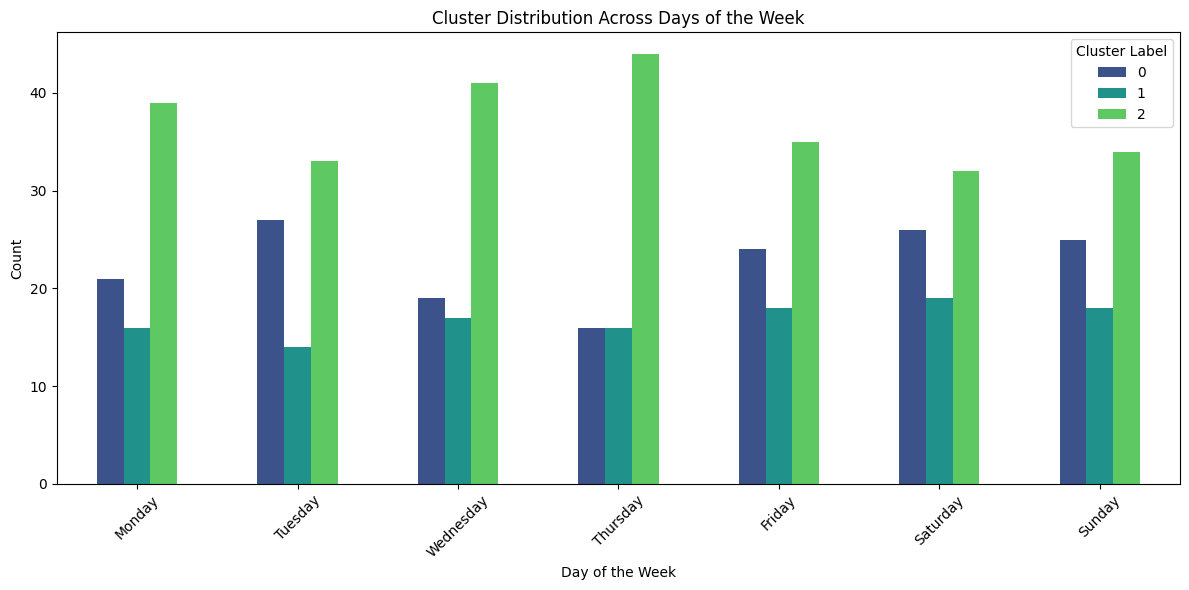

In [16]:
cluster_day_distribution.plot(kind='bar', figsize=(12, 6), color=sns.color_palette('viridis', len(cluster_day_distribution.columns)))
plt.title('Cluster Distribution Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()

## Summary

### Data Analysis Key Findings

* **Cluster Characteristics:** Three distinct sleep clusters were identified based on Heart Rate and HRV:
  * Cluster 0 is characterized by higher mean heart rate and standard deviation, with lower mean HRV and standard deviation.
  * Cluster 1 shows moderate mean heart rate and standard deviation, with higher mean HRV and standard deviation.
  * Cluster 2 has lower mean heart rate and standard deviation, with lower mean HRV and standard deviation.
* **Day of the Week:** The distribution of clusters across days of the week showed some variations, but no extremely strong patterns were immediately obvious from the counts alone.
* **Workout Days:** Due to a lack of overlap between workout dates and sleep dates in the dataset, the relationship between workout days and sleep clusters could not be analyzed. There were no sleep records that fell on a day identified as a workout day.
* **Screen Time:** The average screen time was consistently zero across all clusters. This indicates a data availability or processing issue, preventing the analysis of its relationship with sleep clusters.

### Insights or Next Steps

* The three clusters likely represent different physiological states during sleep, with Cluster 0 potentially indicating stress or poor recovery, Cluster 1 suggesting better recovery, and Cluster 2 requiring further investigation.
* Future analysis requires complete and accurately processed data for workout days and screen time to identify potential behavioral triggers for the observed sleep patterns.